### Importing Libraries
In this cell, we import the essential libraries required for our data prediction project using a Recurrent Neural Network (RNN). These libraries include:

- `pandas` for data manipulation and analysis.
- `numpy` for numerical computations.
- `matplotlib.pyplot` for data visualization.
- `tensorflow` and `keras` for building and training the RNN model.

In [6]:
import pandas as pd

import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Normalization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error


import matplotlib.pyplot as plt

### Loading and Preprocessing Data
In this cell, we load our dataset and perform the necessary preprocessing steps. These steps include:

1. **Loading the dataset**: Using `pandas` to read the data from a file (e.g., CSV).
2. **Handling missing values**: Cleaning the data by handling or removing missing values.
3. **Reorganizing the data**: Reorganizing the data to make our model functional.


In [7]:
#read the data

activitats = pd.read_csv('data/activitats.csv')
notes = pd.read_csv('data/notes_arreglat.csv')
trameses = pd.read_csv('data/trameses_arreglat.csv')



In [8]:

# Filter activitats to keep only entries with an activitat_id present in trameses
activitats_filtered = activitats[activitats['activitat_id'].isin(trameses['activitat_id'].unique())]


In [9]:
# Create a dictionary to map each unique activitat to a unique ID
activitat_unique_id = {activitats_filtered: idx for idx, activitats_filtered in enumerate(activitats_filtered['activitat'].unique(), start=1)}

# Map the activitat values to the unique IDs in the pastas column
activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)



/tmp/ipykernel_213025/311735768.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  activitats_filtered['shared_id'] = activitats_filtered['activitat'].map(activitat_unique_id)


In [10]:
# Define the aula_id values to filter
aula_ids = [87, 92, 143, 141]

activitats_filtered = activitats_filtered[activitats_filtered['aula_id'].isin(aula_ids)]




In [11]:
trameses_updated = trameses.merge(activitats_filtered[['activitat_id','aula_id']], on='activitat_id', how='left')
trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]

### Filling Missing Tramesa Entries
In this cell, we are filling each user with new tramesa entries with a grade of 0 for each tramesa they hadn't done. This ensures that all users have the same number of tramesa entries, which is necessary for training the RNN model.

In [12]:

# Step 1: Create a dictionary of unique activities per aula_id
unique_activities_per_aula = activitats_filtered.groupby('aula_id')['activitat_id'].unique().to_dict()

# Step 2: Get unique pairs of (userid, aula_id) from the existing data
unique_user_aula_pairs = trameses_updated[['userid', 'aula_id']].drop_duplicates()
unique_user_aula_pairs = unique_user_aula_pairs[unique_user_aula_pairs['aula_id'].notna()]

# Step 3: Initialize a list to store new entries
new_entries = []
id = 853717



# Step 4: Iterate over each (userid, aula_id) pair
for _, row in unique_user_aula_pairs.iterrows():
    userid = row['userid']
    aula_id = row['aula_id']

    
    # Get all activities associated with this aula_id
    required_activities = unique_activities_per_aula.get(aula_id, [])
    
    # Get activities that this user already has for the current aula_id
    existing_activities = trameses_updated[(trameses_updated['userid'] == userid) & (trameses_updated['aula_id'] == aula_id)]['activitat_id']
    
    # Find missing activities
    missing_activities = set(required_activities) - set(existing_activities)
    
    # Add a new entry for each missing activity
    for activitat_id in missing_activities:
        id +=1

        new_entry = {
            'id': id,  # Generate an id if needed
            'activitat_id': activitat_id,
            'userid': userid,
            'datesubmitted': 1729605824,  # Fill with appropriate date if needed
            'grade': 0,
            'nevaluations': 0,
            'aula_id': aula_id,
            
        }
        new_entries.append(new_entry)

# Step 5: Create a DataFrame for the new entries and combine it with the existing entries
new_entries_df = pd.DataFrame(new_entries)
trameses_updated = pd.concat([trameses_updated, new_entries_df], ignore_index=True)

# Step 6: Save the updated DataFrame to a new CSV


In [13]:
keywords = {
        "(OPCIONAL)": 3,

    "Problema": 1,
    "Entrega Practica": 2,
    "Entrega Pràctica": 2,
    "Lliurament Practica": 2,
    "Lliurament Pr�ctica": 2,
    "Lliurament Pràctica": 2,
    "Pr�ctica": 2,
    "RECUPERACI�": 6,
    "Recuperació": 6,
    "RECUPERACIÓ": 6,
    "Final FP": 4,
    "Exercici": 5,
    # Add more keywords and labels as needed
}

# Function to check for keywords in each activitat entry and assign a label
def label_activity(activitat):
    for keyword, label in keywords.items():
        if keyword in activitat:
            return label
    return 0  # Default label if no keywords match

# Apply the function to create a new 'label' column
activitats_filtered['label'] = activitats_filtered['activitat'].apply(label_activity)


In [14]:
# Load datasets
activitats = activitats_filtered
# rename the column 'grade' to 'max_grade'
activitats.rename(columns={'grade': 'max_grade'}, inplace=True)

trameses_updated = trameses_updated.merge(activitats[['activitat_id','shared_id','label','max_grade']], on='activitat_id', how='left')



trameses_updated = trameses_updated[trameses_updated['aula_id'].notna()]
# Save the updated trameses dataset




In [15]:
trameses_updated = trameses_updated.sort_values(by=['shared_id', 'userid'])

In [16]:

# Initialize a dictionary to store data for each (userid, aula_id) pair
user_data = {}

# Iterate through each row in trameses
max_len = 0
for _, row in trameses_updated.iterrows():
    user_id = row['userid']
    aula_id = row['aula_id']
    grade = row['grade']
    max_grade = row['max_grade']
    shared_id = row['shared_id']
    nevaluations = row['nevaluations']
    label = row['label']
    datesubmitted = row['datesubmitted']
    
    # Use (userid, aula_id) tuple as a unique key in the dictionary
    key = (user_id, aula_id)
    
    # Initialize the list for this user-aula pair if not already created
    if key not in user_data:
        user_data[key] = []
    if(label in [1,2,3]):
        user_data[key].append([grade/max_grade,shared_id, nevaluations,label]
                          
    )
    if len(user_data[key]) > max_len:
        max_len = len(user_data[key])

print(max_len)

162


In [17]:
# Flatten the user_data dictionary into an array
user_data_array = []
for key, values in user_data.items():
    user_data_array.append(np.array(values))
print(user_data_array[0])

user_data_array = np.array(user_data_array, dtype=object)


# Create a new array to store the F_Grade for each (userid, aula_id) combination
f_grade_array = []

# Iterate through the user_data_array and fetch the corresponding F_Grade from notes
for key, values in user_data.items():
    userid, aula_id = key[0], key[1]
    f_grade = notes.loc[(notes['userid'] == userid) & (notes['aula_id'] == aula_id), 'F_Grade']
    if not f_grade.empty:
        f_grade_array.append(f_grade.values[0])
    else:
        f_grade_array.append(np.nan)  # Append NaN if no F_Grade is found
    last = key
f_grade_array = np.array(f_grade_array)

print("User Data Array:")
print(user_data_array)
print("F_Grade Array:")
print(f_grade_array)



[[  1.     1.     1.     1.  ]
 [  1.     2.     4.     1.  ]
 [  1.     3.     1.     1.  ]
 [  1.     4.     3.     1.  ]
 [  1.     5.     3.     1.  ]
 [  1.     6.     2.     1.  ]
 [  1.     7.     2.     1.  ]
 [  0.     8.     0.     1.  ]
 [  1.    10.     1.     1.  ]
 [  1.    11.     1.     1.  ]
 [  1.    13.     1.     1.  ]
 [  1.    14.     4.     1.  ]
 [  1.    15.     1.     3.  ]
 [  1.    16.     1.     1.  ]
 [  1.    17.     1.     1.  ]
 [  1.    18.     1.     1.  ]
 [  1.    19.     1.     3.  ]
 [  1.    20.     1.     1.  ]
 [  1.    21.     1.     1.  ]
 [  1.    22.    17.     1.  ]
 [  1.    23.     1.     1.  ]
 [  0.97  24.     3.     1.  ]
 [  0.99  25.     4.     1.  ]
 [  1.    26.     1.     3.  ]
 [  1.    27.    14.     1.  ]
 [  1.    28.     1.     1.  ]
 [  0.96  29.     1.     1.  ]
 [  1.    30.     2.     1.  ]
 [  1.    31.     2.     3.  ]
 [  0.99  32.     2.     1.  ]
 [  0.    33.     0.     3.  ]
 [  0.96  34.     1.     1.  ]
 [  0.8 

In [18]:
print(len(user_data_array))

704


In [19]:
# Find the indices where f_grade_array is NaN
nan_indices = np.isnan(f_grade_array)
# Filter out the elements in user_data_array and f_grade_array where the indices match NaN
user_data_array_filtered = user_data_array[~nan_indices]
f_grade_array_filtered = f_grade_array[~nan_indices]
print(len(f_grade_array_filtered))



701


### Building the RNN Model
In this cell, we define the architecture of our Recurrent Neural Network (RNN). This involves:

1. **Defining the model**: Using `keras` to create a Sequential model.
2. **Adding layers**: Adding RNN layers (e.g., LSTM or GRU) to the model.
3. **Specifying activation functions**: Choosing appropriate activation functions for each layer.
4. **Compiling the model**: Specifying the optimizer, loss function, and metrics for model training.

In [20]:




# Example array


# Split the array into 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(user_data_array_filtered, f_grade_array_filtered, test_size=0.2, random_state=79)

# Pad the sequences to ensure equal length
X_train = pad_sequences(X_train, padding='post')
X_test = pad_sequences(X_test, padding='post')

# Create the RNN model

regressor = Sequential([
    Normalization(),
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[0], X_train.shape[1])),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True,),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

# Compiling the RNN

# Fit the normalization layer
normalizer = regressor.layers[0]
normalizer.adapt(X_train)

# Compile the model
regressor.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
# Define the path to save the model
checkpoint_filepath = 'best_model.keras'

# Create the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',          # Monitor validation loss
    save_best_only=True,         # Save only the model with the lowest val_loss
    save_weights_only=False,     # Save the full model, not just the weights
    mode='min',                  # Minimize the val_loss
    verbose=1                    # Print updates
)

# Train the model and include the checkpoint callback
regressor.fit(X_train, y_train, epochs=300, batch_size=64, callbacks=[checkpoint_callback]  ,validation_split=0.05# Pass the checkpoint callback to fit
)

regressor.save('model.keras')



Epoch 1/300


2024-10-27 11:05:01.322305: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/home/jordi/anaconda3/envs/Rectangles_env/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 29.7834
Epoch 1: val_loss improved from inf to 15.77823, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 232ms/step - loss: 29.4640 - val_loss: 15.7782
Epoch 2/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step - loss: 13.1708
Epoch 2: val_loss improved from 15.77823 to 6.13014, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 12.9639 - val_loss: 6.1301
Epoch 3/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 7.8079
Epoch 3: val_loss did not improve from 6.13014
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - loss: 7.8237 - val_loss: 6.1493
Epoch 4/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 8.2195
Epoch 4: val_loss did not improve from 6.13014
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step - loss: 8.1788 - val_loss: 6.4978
Epoch 5/300
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 7.4867
Epoch 5: val_loss improved from 6.13014 to 5.08321, saving model to best_model.keras
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step

### Making Predictions
We use the trained model to make predictions on new, unseen data. This step demonstrates how the model can be used in a real-world scenario.

In [29]:

# Assuming `predicted_final_mark` is the vector of your predictions
# and `y_test` is the ground truth vector
normalizer = regressor.layers[0]
normalizer.adapt(X_test)
predicted_final_mark = regressor.predict(X_test)
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predicted_final_mark)
print(f"Mean Absolute Error (MAE): {mae}")
# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predicted_final_mark)
print(f"Mean Squared Error (MSE): {mse}")

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(max(y_test))

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Mean Absolute Error (MAE): 2.029001019119371
Mean Squared Error (MSE): 5.939477251864361
Root Mean Squared Error (RMSE): 2.437104275952172
10.0


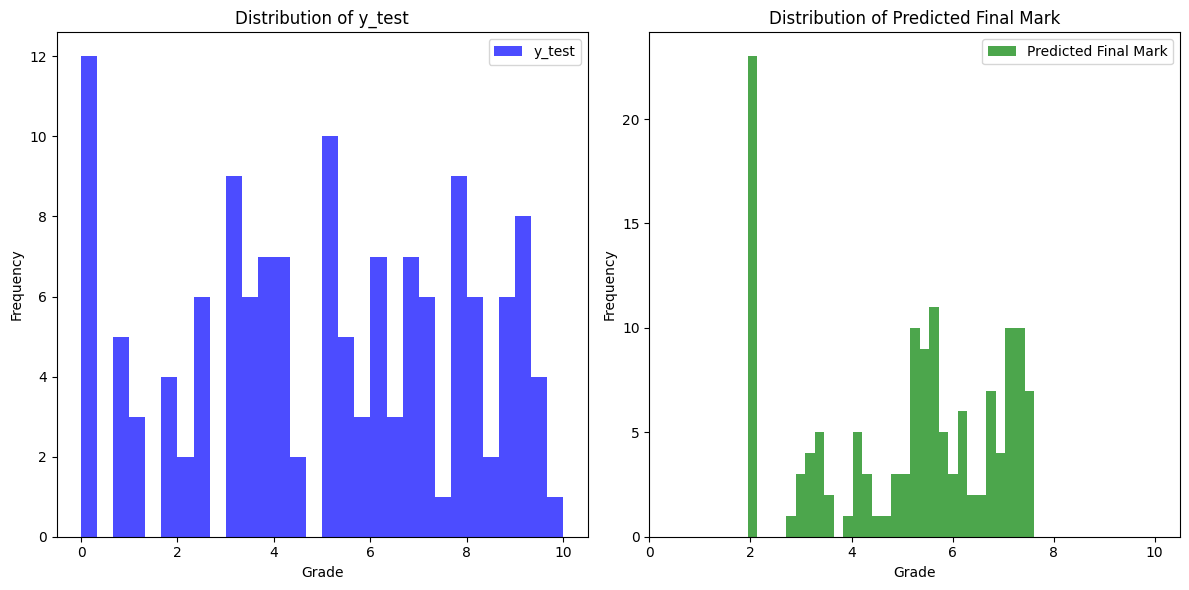

In [30]:

# Plot the distribution of y_test
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(y_test, bins=30, alpha=0.7, color='blue', label='y_test')
plt.title('Distribution of y_test')
plt.xlabel('Grade')
plt.ylabel('Frequency')
plt.legend()

# Plot the distribution of predicted_final_mark
plt.subplot(1, 2, 2)
plt.hist(predicted_final_mark, bins=30, alpha=0.7, color='green', label='Predicted Final Mark')
plt.title('Distribution of Predicted Final Mark')
plt.xlabel('Grade')
plt.xlim([0, 10.5])
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

In [28]:
#regressor.save('model.keras')

In [25]:
#regressor.load_weights("best_model.keras")